# Working from Remote Geophysical data 

Examples of accessing Netcdf data via TRHEDDS/OPENDAP serivces in Python, and plotting in Basemaps

In [10]:
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, date2index
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
%matplotlib notebook

In [2]:
nc = Dataset('http://www.ncdc.noaa.gov/thredds/dodsC/OISST-V2-AVHRR_agg')

In [3]:
nc.variables  # See the metadata via this

OrderedDict([('zlev', <class 'netCDF4._netCDF4.Variable'>
              float32 zlev(zlev)
                  long_name: Sea surface height
                  units: meters
                  actual_range: 0, 0
                  _CoordinateAxisType: Height
              unlimited dimensions: 
              current shape = (1,)
              filling off), ('lat', <class 'netCDF4._netCDF4.Variable'>
              float32 lat(lat)
                  long_name: Latitude
                  units: degrees_north
                  grids: Uniform grid from -89.875 to 89.875 by 0.25
              unlimited dimensions: 
              current shape = (720,)
              filling off), ('lon', <class 'netCDF4._netCDF4.Variable'>
              float32 lon(lon)
                  long_name: Longitude
                  units: degrees_east
                  grids: Uniform grid from 0.125 to 359.875 by 0.25
              unlimited dimensions: 
              current shape = (1440,)
              filling off), 

<IPython.core.display.Javascript object>


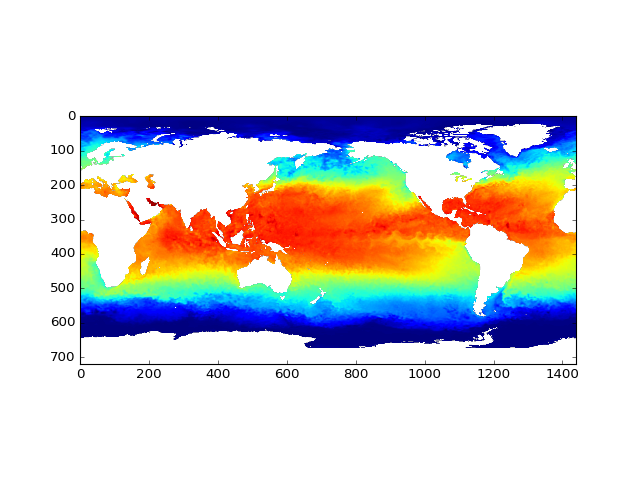

In [17]:
# Grab a slice of the SST to play with
# nc.variables['sst']
sst = nc.variables['sst'][0,:].squeeze()

# preview the data with an array plotting function from matplotlib
fig, ax = plt.subplots(1,1)
ax.imshow(np.flipud(sst))

In [26]:
lon, lat =  sst.shape
print("Number of (floating point value) pixels of AVHRR data retrieved: {0:10,}".format(lon * lat))
print("Size in memory: {0:3.1f} mb".format(16 * (lon*lat)/1000000)) # 16 bytes in a float, 1 million bytes in a megabyte

Number of (floating point value) pixels of AVHRR data retrieved:  1,036,800
Size in memory: 16.6 mb


## Use Basemaps to project these data onto a map

In [ ]:
%%time
# based on example at http://matplotlib.org/basemap/users/examples.html
date = datetime(2007,12,15,0)    # Specify date to plot.
dataset = Dataset('http://www.ncdc.noaa.gov/thredds/dodsC/OISST-V2-AVHRR_agg')
timevar = dataset.variables['time']
timeindex = date2index(date, timevar) # find time index for desired date.

# read sst.  Will automatically create a masked array using
# missing_value variable attribute. 'squeeze out' singleton dimensions.
sst = dataset.variables['sst'][timeindex,:].squeeze()
# read ice.
ice = dataset.variables['ice'][timeindex,:].squeeze()

# read lats and lons (representing centers of grid boxes).
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
lons, lats = np.meshgrid(lons,lats)

# create figure, axes instances.
fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])
# create Basemap instance.
# coastlines not used, so resolution set to None to skip
# continent processing (this speeds things up a bit)
m = Basemap(projection='kav7',lon_0=0,resolution=None)
m.drawmapboundary(fill_color='0.3') # color map background
# plot sst, then ice with pcolor
im1 = m.pcolormesh(lons, lats, sst, shading='flat', cmap=plt.cm.jet, latlon=True)
im2 = m.pcolormesh(lons, lats, ice, shading='flat', cmap=plt.cm.gist_gray, latlon=True)
# draw parallels and meridians, but don't bother labelling them.
#m.drawparallels(np.arange(-90.,99.,30.))
#m.drawmeridians(np.arange(-180.,180.,60.))
# add colorbar
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
# add a title.
ax.set_title('SST and ICE location on {0}'.format(date.date()))
plt.show()

## More complex example - multiple datasets accessed and overlaid

In [ ]:
from mpl_toolkits.basemap import shiftgrid

In [ ]:
# specify date to plot.
date = datetime(1993, 3, 14, 0)

# set OpenDAP server URL.
URLbase="http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_pgbh/"
URL=URLbase+"%04i/%04i%02i/%04i%02i%02i/pgbh00.gdas.%04i%02i%02i%02i.grb2" %\
             (yyyy,yyyy,mm,yyyy,mm,dd,yyyy,mm,dd,hh)
    
data = Dataset(URL)
latitudes = data.variables['lat'][::-1]
longitudes = data.variables['lon'][:].tolist()
# get sea level pressure and 10-m wind data.
slpin = 0.01*data.variables['Pressure_msl'][:].squeeze() # mult slp by 0.01 to put in units of hPa.
uin = data.variables['U-component_of_wind_height_above_ground'][:].squeeze()
vin = data.variables['V-component_of_wind_height_above_ground'][:].squeeze()
# add cyclic points manually (could use addcyclic function)
slp = np.zeros((slpin.shape[0],slpin.shape[1]+1),np.float)
slp[:,0:-1] = slpin[::-1]; slp[:,-1] = slpin[::-1,0]
u = np.zeros((uin.shape[0],uin.shape[1]+1),np.float64)
u[:,0:-1] = uin[::-1]; u[:,-1] = uin[::-1,0]
v = np.zeros((vin.shape[0],vin.shape[1]+1),np.float64)
v[:,0:-1] = vin[::-1]; v[:,-1] = vin[::-1,0]
longitudes.append(360.); longitudes = np.array(longitudes)
# make 2-d grid of lons, lats
lons, lats = np.meshgrid(longitudes,latitudes)
# make orthographic basemap.
m = Basemap(resolution='c',projection='ortho',lat_0=60.,lon_0=-60.)
# create figure, add axes
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])
# set desired contour levels.
clevs = np.arange(960,1061,5)
# compute native x,y coordinates of grid.
x, y = m(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
# plot SLP contours.
CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)
# plot wind vectors on projection grid.
# first, shift grid so it goes from -180 to 180 (instead of 0 to 360
# in longitude).  Otherwise, interpolation is messed up.
ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
# transform vectors to projection grid.
uproj,vproj,xx,yy = \
m.transform_vector(ugrid,vgrid,newlons,latitudes,31,31,returnxy=True,masked=True)
# now plot.
Q = m.quiver(xx,yy,uproj,vproj,scale=700)
# make quiver key.
qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')
# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)
# add colorbar
cb = m.colorbar(CS2,"bottom", size="5%", pad="2%")
cb.set_label('hPa')
# set plot title
ax.set_title('SLP and Wind Vectors '+str(date))
plt.show()